In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Predict The News Category Hackathon**

From the beginning, since the first printed newspaper, every news that makes into a page has had a specific section allotted to it. Although pretty much everything changed in newspapers from the ink to the type of paper used, this proper categorization of news was carried over by generations and even to the digital versions of the newspaper. Newspaper articles are not limited to a few topics or subjects, it covers a wide range of interests from politics to sports to movies and so on. For long, this process of sectioning was done manually by people but now technology can do it without much effort. In this hackathon, we will use Natural Language Processing to predict which genre or category a piece of news will fall in to from the story.


Import all the required Libraries

In [2]:
import pandas as pd 
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout
import warnings
from keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
data = pd.read_excel('/content/drive/My Drive/News_category/Data_Train.xlsx')
data.head()

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


There are four distinct sections where each story may fall in to. The Sections are labelled as follows :

Politics: 0

Technology: 1

Entertainment: 2

Business: 3

In [3]:
#Let's look into the shape of the data
data.shape

(7628, 2)

In [4]:
data.iloc[0,0] #Sample Story

'But the most painful was the huge reversal in fee income, unheard of among private sector lenders. Essentially, it means that Yes Bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books. As borrowers turned defaulters, the fees tied to these loan deals fell off the cracks. Gill has now vowed to shift to a safer accounting practice of amortizing fee income rather than booking these upfront.\n\n\nGill’s move to mend past ways means that there will be no nasty surprises in the future. This is good news considering that investors love a clean image and loathe uncertainties.\n\n\nBut there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well. Investors will have to give up the hopes of phenomenal growth, a promise made by Kapoor.'

**Data visualization**

In [0]:
mask = np.array(Image.open('/content/drive/My Drive/News_category/batman-logo.png'))

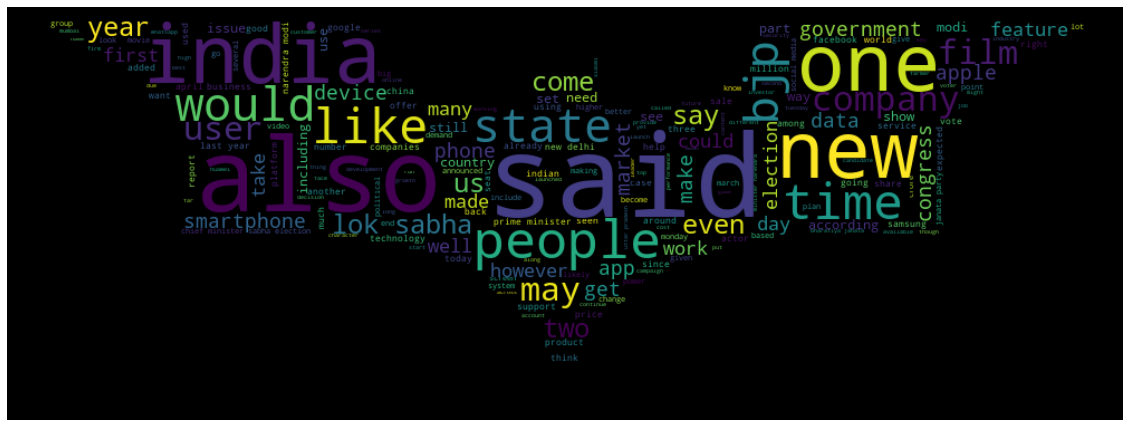

In [6]:
stop_words = stopwords.words('english')#Remove the stopwords like is,the,in ect.
text = ' '.join(data['STORY'].str.lower())
cloud = WordCloud(mask=mask,random_state=21,stopwords = stop_words).generate(text)
plt.figure(figsize = (20,10))
plt.imshow(cloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [7]:
text = ' '.join(data['STORY'].str.lower())
text = re.sub('[^a-z]',' ',text)
words = [word for word in text.split() if word not in stop_words]
freq = nltk.FreqDist(words)
freq_df = pd.DataFrame({'WORDS' : list(freq.keys()),'COUNT' : list(freq.values())})
freq_df.head()

,WORDS,COUNT
0,painful,8
1,huge,130
2,reversal,7
3,fee,28
4,income,200


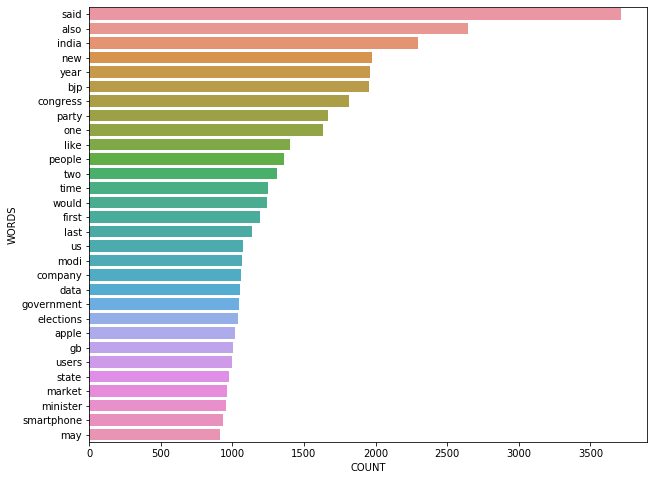

In [8]:
plt.figure(figsize = (10,8))
top_n = freq_df.nlargest(30,columns='COUNT')
sns.barplot(data = top_n,x = 'COUNT',y = 'WORDS')


*WordCloud on politics*

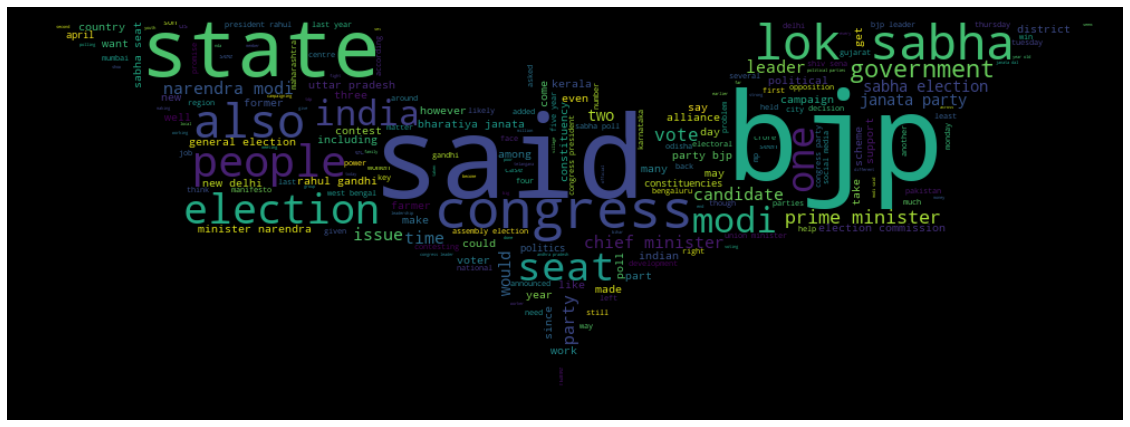

In [9]:
politics_text = " ".join(data['STORY'][data['SECTION'] == 0].str.lower())
politics_wordcloud = WordCloud(stopwords=stop_words,mask = mask,random_state= 42).generate(politics_text)
plt.figure(figsize = (20,10))
plt.imshow(politics_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

*WordCloud on technology*

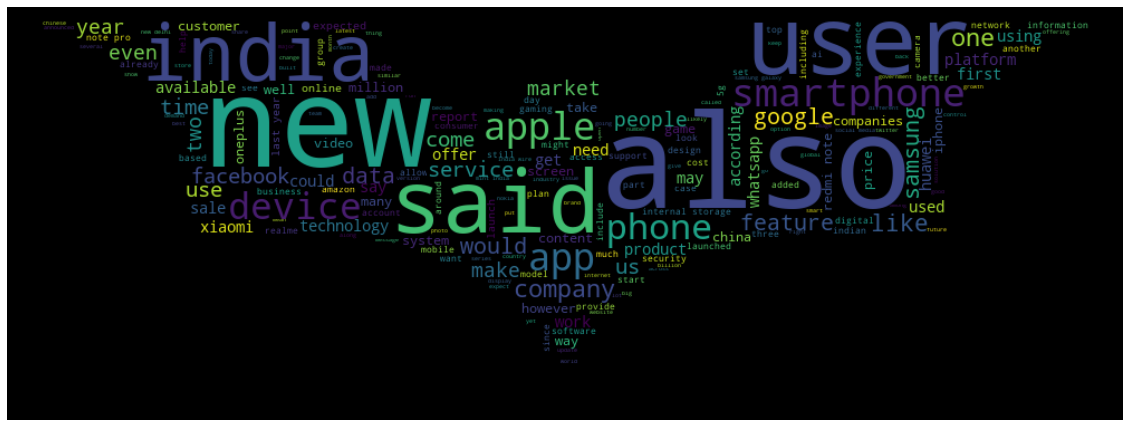

In [10]:
technology_text = ' '.join(data['STORY'][data['SECTION'] == 1].str.lower())
technology_wordcloud = WordCloud(random_state=42,mask = mask,stopwords=stop_words).generate(technology_text)
plt.figure(figsize=(20,10))
plt.imshow(technology_wordcloud,interpolation= 'bilinear')
plt.axis('off')
plt.show()

*WordCloud on Entertainment*

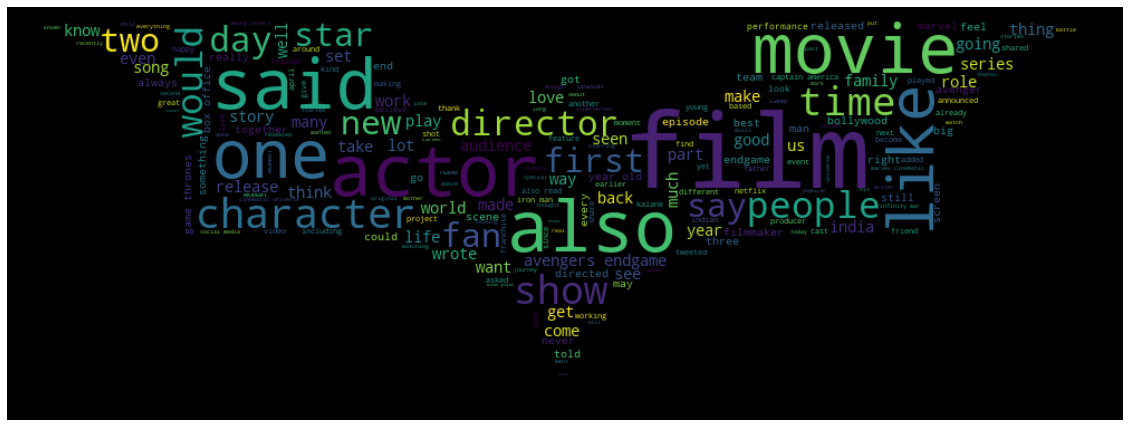

In [11]:
entertainment_text = ' '.join(data['STORY'][data['SECTION'] == 2].str.lower())
entertainment_wordcloud = WordCloud(random_state=42,mask = mask,stopwords=stop_words).generate(entertainment_text)
plt.figure(figsize=(20,10))
plt.imshow(entertainment_wordcloud,interpolation= 'bilinear')
plt.axis('off')
plt.show()

*WordCloud on Business*

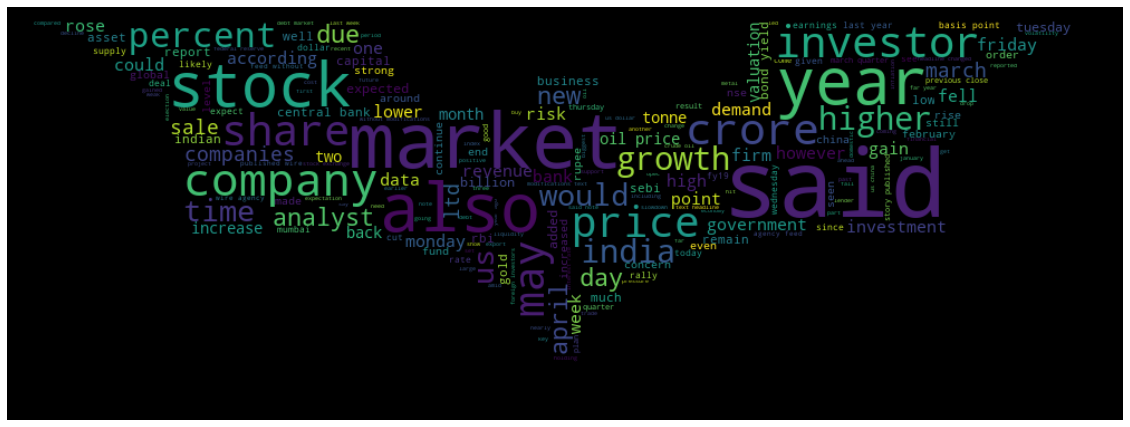

In [12]:
business_text = ' '.join(data['STORY'][data['SECTION'] == 3].str.lower())
business_wordcloud = WordCloud(random_state=42,mask = mask,stopwords=stop_words).generate(business_text)
plt.figure(figsize=(20,10))
plt.imshow(business_wordcloud,interpolation= 'bilinear')
plt.axis('off')
plt.show()

**Text Preprocessing**

In [0]:
def text_clean(data,column):
  data = data[column].str.lower()#Convert the text to lower
  #We will remove the most repeated words like 'said','us','also'
  data = data.str.replace('said','')
  data = data.str.replace('us','')
  data = data.str.replace('also','')
  data = data.apply(lambda x : re.sub(r'[^a-z]',' ',x))#Remove numbers, special characters
  data = data.apply(lambda x : ' '.join([word for word in nltk.word_tokenize(x) if word not in stop_words]))#Stop word removal
  data = data.apply(lambda x : ' '.join([word for word in x.split() if len(word) > 2 ]))
  return data

In [14]:
data['clean'] = text_clean(data,'STORY')
data.head()

,STORY,SECTION,clean
0,But the most painful was the huge reversal in ...,3,painful huge reversal fee income unheard among...
1,How formidable is the opposition alliance amon...,0,formidable opposition alliance among congress ...
2,Most Asian currencies were trading lower today...,3,asian currencies trading lower today south kor...
3,"If you want to answer any question, click on ‘...",1,want answer question click answer clicking ans...
4,"In global markets, gold prices edged up today ...",3,global markets gold prices edged today disappo...


In [15]:
X = data['clean']
Y = data['SECTION']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state = 42,stratify = Y,test_size = 0.2)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((6102,), (1526,), (6102,), (1526,))

In [16]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train).toarray()
X_tfidf.shape

(6102, 27841)

In [17]:
cv = CountVectorizer()
X_cv = cv.fit_transform(X_train)
X_cv.shape

(6102, 27841)

***Model Building***

In [0]:
nb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()

In [0]:
#Custom function to check the model performance
def Model(X,Y,X_test,Y_test,model):
  model.fit(X,Y)
  prediction = model.predict(tfidf.transform(X_test).toarray())
  print(metrics.classification_report(Y_test,prediction))

In [30]:
#Naive Bayes
Model(X = X_tfidf,Y= Y_train,X_test= X_test,Y_test= Y_test,model = nb)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       337
           1       0.89      0.99      0.94       555
           2       0.99      0.90      0.94       385
           3       1.00      0.90      0.95       249

    accuracy                           0.94      1526
   macro avg       0.96      0.94      0.94      1526
weighted avg       0.95      0.94      0.94      1526



In [31]:
#Decision Tree
Model(X = X_tfidf,Y= Y_train,X_test=X_test,Y_test=Y_test,model = dt)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       337
           1       0.90      0.89      0.89       555
           2       0.89      0.88      0.89       385
           3       0.87      0.88      0.87       249

    accuracy                           0.89      1526
   macro avg       0.89      0.89      0.89      1526
weighted avg       0.89      0.89      0.89      1526



In [0]:
#Random Forest
Model(X = X_tfidf,Y= Y_train,X_test=X_test,Y_test=Y_test,model = rf)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       337
           1       0.92      0.95      0.94       555
           2       0.93      0.95      0.94       385
           3       0.96      0.86      0.90       249

    accuracy                           0.94      1526
   macro avg       0.94      0.93      0.93      1526
weighted avg       0.94      0.94      0.93      1526



In [0]:
Model(X = X_tfidf,Y= Y_train,X_test=X_test,Y_test=Y_test,model = ada)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       337
           1       0.90      0.84      0.87       555
           2       0.77      0.91      0.84       385
           3       0.92      0.86      0.89       249

    accuracy                           0.87      1526
   macro avg       0.88      0.87      0.88      1526
weighted avg       0.88      0.87      0.87      1526



**LSTM Deep Neural Network**

In [32]:
tokenizer = Tokenizer(num_words = 25000,lower = True) #maximum number of words to keep, based on the word frequency
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27841 unique tokens.


In [33]:
data['lengths'] = data['clean'].apply(lambda x : len(x.split())) # Length of the story
data.head()

,STORY,SECTION,clean,lengths
0,But the most painful was the huge reversal in ...,3,painful huge reversal fee income unheard among...,82
1,How formidable is the opposition alliance amon...,0,formidable opposition alliance among congress ...,13
2,Most Asian currencies were trading lower today...,3,asian currencies trading lower today south kor...,30
3,"If you want to answer any question, click on ‘...",1,want answer question click answer clicking ans...,50
4,"In global markets, gold prices edged up today ...",3,global markets gold prices edged today disappo...,35


In [34]:
max(data['lengths'])

540

In [0]:
#Convert the text to tokens
X_token = tokenizer.texts_to_sequences(X_train)

In [0]:
X_token = pad_sequences(X_token,540)

In [0]:
X_token[0]

In [0]:
model = Sequential()
model.add(Embedding(input_dim= 25000,output_dim= 100,input_length=X_token.shape[1]))
model.add(Dropout(0.1))
model.add(LSTM(units=100,dropout=0.1))
model.add(Dense(units = 4,activation = 'softmax'))
model.compile(optimizer = 'adam' , loss= 'categorical_crossentropy',metrics = ['accuracy'])

In [39]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 540, 100)          2500000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 540, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 2,580,804
Trainable params: 2,580,804
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
Y_train = pd.get_dummies(Y_train)
Y_train.head()

,0,1,2,3
1638,0,1,0,0
5586,1,0,0,0
3749,0,1,0,0
4331,0,0,1,0
3338,0,0,1,0


In [0]:
Y_test = pd.get_dummies(Y_test)

In [42]:
model.fit(X_token,Y_train,batch_size= 64,epochs = 5,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4881 samples, validate on 1221 samples
Epoch 1/5





4881/4881 [==============================] - 99s 20ms/step - loss: 0.9043 - acc: 0.6206 - val_loss: 0.4021 - val_acc: 0.8943
Epoch 2/5
4881/4881 [==============================] - 96s 20ms/step - loss: 0.2300 - acc: 0.9430 - val_loss: 0.1749 - val_acc: 0.9582
Epoch 3/5
4881/4881 [==============================] - 95s 20ms/step - loss: 0.0654 - acc: 0.9846 - val_loss: 0.1386 - val_acc: 0.9582
Epoch 4/5
4881/4881 [==============================] - 94s 19ms/step - loss: 0.0410 - acc: 0.9900 - val_loss: 0.2417 - val_acc: 0.9533
Epoch 5/5
4881/4881 [==============================] - 95s 19ms/step - loss: 0.0211 - acc: 0.9943 - val_loss: 0.1141 - val_acc: 0.9656


In [0]:
test_token = tokenizer.texts_to_sequences(X_test)
pad_test = pad_sequences(test_token,540)
predictions = model.predict_classes(pad_test)

In [0]:
predictions = model.predict(pad_test)

In [0]:
test_labels = np.argmax(Y_test.values,axis = 1)

In [46]:
metrics.confusion_matrix(test_labels,np.argmax(predictions,axis = 1))

array([[321,  11,   5,   0],
       [  4, 541,   9,   1],
       [  7,   2, 375,   1],
       [  3,  12,   0, 234]])

In [47]:
print(metrics.classification_report(test_labels,np.argmax(predictions,axis = 1)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       337
           1       0.96      0.97      0.97       555
           2       0.96      0.97      0.97       385
           3       0.99      0.94      0.96       249

    accuracy                           0.96      1526
   macro avg       0.97      0.96      0.96      1526
weighted avg       0.96      0.96      0.96      1526



*LSTM Neural Network performs well*

**Train the model on complete data**

In [49]:
tokenizer = Tokenizer(num_words= 25000)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30460 unique tokens.


In [0]:
X_tokens = tokenizer.texts_to_sequences(X)
X_tokens = pad_sequences(X_tokens,maxlen= 540)

In [0]:
model = Sequential()
model.add(Embedding(input_dim= 25000,output_dim= 100,input_length=X_token.shape[1]))
model.add(Dropout(0.1))
model.add(LSTM(units=100,dropout=0.1))
model.add(Dense(units = 4,activation = 'softmax'))
model.compile(optimizer = 'adam' , loss= 'categorical_crossentropy',metrics = ['accuracy'])

In [0]:
Y = pd.get_dummies(Y)

In [53]:
model.fit(X_tokens,Y,batch_size= 64,epochs = 5)

Epoch 1/5
7628/7628 [==============================] - 143s 19ms/step - loss: 0.7408 - acc: 0.6834
Epoch 2/5
7628/7628 [==============================] - 143s 19ms/step - loss: 0.1142 - acc: 0.9702
Epoch 3/5
7628/7628 [==============================] - 142s 19ms/step - loss: 0.0547 - acc: 0.9866
Epoch 4/5
7628/7628 [==============================] - 141s 18ms/step - loss: 0.0343 - acc: 0.9910
Epoch 5/5
7628/7628 [==============================] - 139s 18ms/step - loss: 0.0193 - acc: 0.9951


**Load the Test Data**

In [54]:
test = pd.read_excel('/content/drive/My Drive/News_category/Data_Test.xlsx')
test.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [0]:
test['clean'] = text_clean(test,'STORY')

*Tokenize the test data*

In [0]:
test_tokens = tokenizer.texts_to_sequences(test['clean'])
test_tokens = pad_sequences(test_tokens,maxlen= 540)

*Predict the test data*

In [0]:
predictions = model.predict_classes(test_tokens)

In [58]:
Sample_submission = pd.DataFrame({'SECTION' : predictions})
Sample_submission.head() 

,SECTION
0,1
1,2
2,1
3,0
4,1


In [0]:
Sample_submission.to_excel('/content/drive/My Drive/News_category/Sample_submission.xlsx')